# Lecture 15: ML and Persistence with Python



## Class notes and reminders

- No class next week since Liz is travelling. 
- The following class is Tuesday, Nov 4, at the usual time. 

### Homework for everyone!

Pick a lecture from the AATRN YouTube channel focused on Persistence, preferably one that uses machine learning, deep learning, and/or vectorization in some form. Write a post prior to next class on the Slack channel with: 
- A link to the video you watched.
- A brief summary of the problem setup and take-away message of the talk. 
- If applicable: what did they use for vectorization for their particular persistence diagrams. What choices were made for this vectorization (e.g. number of landscapes, grid sizes, number of DL layers, *etc.*). 

## What are we up to? 

In this lecture, we're going to use all the vectorization methods for persistence that we went over [last class](../14-MLAndPers/index.md). The basic formula is: 

- Take input data. 
- Turn it into persistence using whatever filtration. 
- Turn the persistence diagram into a vector in $\mathbb{R}^n$ using your chosen vectorization method. 

Here, we'll cover the four methods introduced last time. 

- [Algebraic Carlsson Coordinates](https://dx.doi.org/10.4310/HHA.2016.v18.n1.a21)
- [Persistence Landscapes](https://www.jmlr.org/papers/volume16/bubenik15a/bubenik15a.pdf)
- [Persistence Images](https://jmlr.org/papers/v18/16-337.html)
- [Template Functions](https://doi.org/10.1007/s10208-022-09567-7)

We're going to do that by recreating some experiments that I used [in my paper defining template functions](https://doi.org/10.1007/s10208-022-09567-7), but can be applied to any sort of ML vectorization. The game is to generate some simple test data sets and then use the various methods to predict the label/input parameter values of these data points. 

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

%matplotlib inline

import teaspoon.MakeData.PointCloud as gPC
import teaspoon.TDA.Draw as Draw
import teaspoon.ML.feature_functions as Ff
import teaspoon.ML.Base as MLBase
import teaspoon.ML.PD_Classification as PD_CL

## Generating data

We're going to use two different data sets. These are generated using `teaspoons`'s MakeData module. *([Link to documentation](https://teaspoontda.github.io/teaspoon/modules/MakeData/PointCloud.html))*


### Diagrams from normally distributed points
To start, we're going to use the dumbest example we could think of. 

First, we're going to generate data points that don't come from any sort of input data. All we're going to do is generate points in a "persistence diagram" *(picture Liz doing giant air quotes as she says this...)* using different distributions, and then see if the vectorization methods can tell them apart. 

To do this, we will:

- Fix $\mu$ and $\sigma$
- generate $n$ points in $\mathbb{R}^2$ from normal distribution $N(\mu,\sigma)$. 
- Discard any points that are below the diagonal (i.e. drop any point $(a,b)$ with $b<a$)

Here is a figure of some example data with the $\mu$ values given as center.

<img src="https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/ExampleDgms-RandomOffDiagPts.png" alt="Example of persistence diagrams with random points" style="width: 500px;"/>



Next, we'll actually generate two diagrams ourselves. 

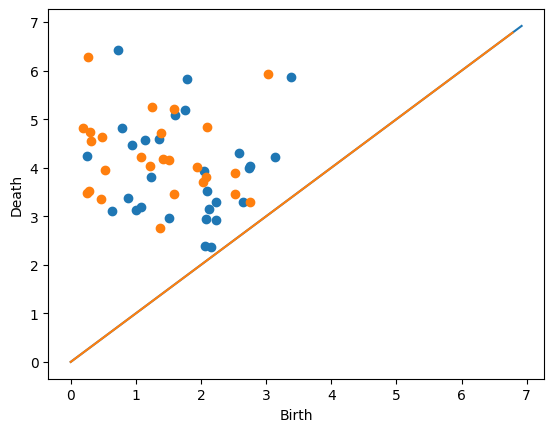

In [2]:
D = gPC.normalDiagram(N = 30, mu = (2,4), sd = 1)
Draw.drawDgm(D)

D = gPC.normalDiagram(N = 30, mu = (1,4), sd = 1)
Draw.drawDgm(D)

#### Now generate a lot of diagrams but with different means

The goal eventually: Build a classifier that can decide which of the two means generated the fake diagram. So, we're going to make ourselves a big data frame with lots of persistence diagrams, each generated from a different mean. 

In [3]:
simpleDF = gPC.testSetClassification(N=20,
                          numDgms=(100, 100),
                          muRed=(1, 3),
                          muBlue=(3, 6),
                          sd=1)

simpleDF.shape
# If the mean column shows all the same value, you can update your teaspoon since I fixed a bug yesterday. It won't affect anything though because it's the trainingLabel column that we are actually going to use. 

(200, 4)

Each diagram is stored in the `Dgm` column as a `#(points) x 2` array.

In [4]:
#  single diagram 
simpleDF.iloc[0,0]

array([[1.14349805, 3.30032222],
       [0.46946275, 4.72457635],
       [3.14492053, 4.50469178],
       [1.52135184, 2.91899649],
       [0.19372646, 3.61719528],
       [0.73090455, 3.80383984],
       [0.01119941, 2.73530921],
       [1.30796422, 4.60044478],
       [0.87315116, 3.05549408],
       [1.51944287, 3.29778742],
       [2.00093196, 2.93147697],
       [0.89056517, 2.47013509],
       [0.09371519, 4.53064326],
       [1.05670737, 1.69325201],
       [2.76979064, 3.41842944],
       [2.82274596, 4.66205581]])

### Diagrams sampled from manifolds

Next, we'll generate a data set that comes from some standard manifolds to actually see how this works. 

In this case, we have point clouds drawn from six example spaces, all using the default inputs from the teaspoon functions.

- **Torus**: A torus embedded in $\mathbb{R}^3$ using the function `Torus()`.
- **Annulus**: An annulus generated with default inputs of `Annulus()`.
- **Cube**: Points drawn uniformly from the cube $[0,1]^3 \subset \mathbb{R}^3$ using the function `Cube()`.
- **3Cluster**: Points are drawn using Clusters() with centers $[0,0]$, $[0,1.5]$, $[1.5,0]$ with `sd = 0.05`.
- **3Clusters of 3Clusters**: Points are drawn with 9 different centers, which can be loosely grouped into three groups of three; again uses `Clusters()` with `sd = 0.05`. The centers are $[0,0]$, $[0,1.5]$, $[1.5,0]$; this set rotated 45 degrees and shifted up by 4; and the first set shifted right 3 and up 4.
- **Sphere**: Points drawn from a sphere using `Sphere()` with `noise = .05`.

![Manifold data set example](https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/ManifoldExperiment.jpg)


In [5]:
# This will take longer than the other example since it does have to compute persistence for 6*numDgms point clouds. For speedups, you can decrease the number of diagrams or the number of points sampled in each point cloud. 
manifoldDF = gPC.testSetManifolds(numDgms = 50, 
                                  numPts= 500, 
                                  seed = 42)

manifoldDF.reset_index(drop=True, inplace=True)

In this example, we track the 0- and 1-dimensinoal diagrams in the two columns, plus a `trainingLabel` column which we will use for classification later. 

In [6]:
manifoldDF.head()

Dgm0  \
0  [[0.0, 0.009180114604532719], [0.0, 0.01371909...   
1  [[0.0, 0.007567704655230045], [0.0, 0.00768248...   
2  [[0.0, 0.0054537588730454445], [0.0, 0.0107017...   
3  [[0.0, 0.020688075572252274], [0.0, 0.03624243...   
4  [[0.0, 0.004080696031451225], [0.0, 0.00557038...   

                                                Dgm1           trainingLabel  
0  [[0.860607385635376, 0.9120365977287292], [0.8...                   Torus  
1  [[0.46230122447013855, 0.48311299085617065], [...                  Sphere  
2  [[0.30187922716140747, 0.3032122552394867], [0...                 Annulus  
3  [[0.8614302277565002, 0.9710468053817749], [0....                   Torus  
4  [[1.7299253940582275, 1.7423832416534424], [1....  3Clusters of 3Clusters

We can get out one of the rows as follows. 

In [7]:
manifoldDF.loc[14]

Dgm0             [[0.0, 0.005057202652096748], [0.0, 0.00709510...
Dgm1             [[0.35105574131011963, 0.38014885783195496], [...
trainingLabel                                              Annulus
Name: 14, dtype: object

We can also take a look at the individual diagrams. Since this particular example came from an annulus (as seen in the trainingLabel entry above), it's good that we're seeing one prominent off-diagonal point in the 1-dimensional diagram. 

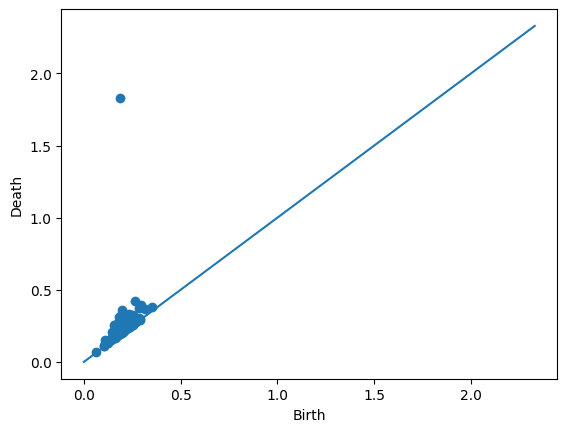

In [8]:
Draw.drawDgm(manifoldDF.loc[14]['Dgm1'])

## Vectorization Methods

Next, we're going to set up the vectorization methods that we discussed last time. For this, we'll be using teaspoon; see [the teaspoon Machine Learning documentation](https://teaspoontda.github.io/teaspoon/modules/ML/index.html) for more information and other available methods. 

### Carlsson Coordinates 



This code generates feature matrix to be used in machine learning applications using Carlsson Coordinates which is composed of five different functions shown in Eq. :eq:`1st_coord` - :eq:`5th_coord`.

- $f_{1}(PD) = \sum b_{i}(d_{i}-b_{i})$
- $f_{2}(PD) = \sum (d_{max}-d_{i})(d_{i}-b_{i})$
- $f_{3}(PD) = \sum b_{i}^{2}(d_{i}-b_{i})^{4}$
- $f_{4}(PD) = \sum (d_{max}-d_{i})^{2}(d_{i}-b_{i})^{4}$
- $f_{5}(PD) = max(d_{i}-b_{i})$

There are two inputs to the function. These are persistence diagrams and number of coordinates that user wants to use in feature matrix.
This particular function is set up to return all combinations of these 5 equations; we'll just focus on the array that gives us all of them. 



In [9]:
simpleDF.Dgm

47     [[1.1434980494203302, 3.300322220934327], [0.4...
19     [[2.109650594345767, 3.095810994799408], [2.28...
98     [[2.372907599303179, 5.532741291182399], [1.57...
53     [[0.5287804192812411, 4.373618143545626], [1.6...
145    [[2.065010718288077, 5.7734580337302335], [3.7...
                             ...                        
24     [[2.0483093648546316, 4.236661283504928], [1.1...
118    [[2.575252042840591, 6.0626563054333635], [3.8...
157    [[3.768537781165112, 6.728387115341577], [2.28...
177    [[2.321539127499081, 5.925163883800649], [2.21...
18     [[0.433962982261067, 2.369740510904326], [1.53...
Name: Dgm, Length: 200, dtype: object

In [10]:
FeatureMatrix, _ , _ = Ff.F_CCoordinates(simpleDF.Dgm, 5)
X = FeatureMatrix[-1]
y = np.array(simpleDF.trainingLabel).astype('int')

In [11]:
print(f"X is a matrix of size {X.shape}")
print(f"y is a vector of size {y.shape}")

X is a matrix of size (200, 5)
y is a vector of size (200,)


Now we can just pass this matrix into our favorite boiler plate SVM model to do prediction: 

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# X: feature matrix, y: label vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.4
              precision    recall  f1-score   support

          -1       0.41      0.43      0.42        30
           1       0.39      0.37      0.38        30

    accuracy                           0.40        60
   macro avg       0.40      0.40      0.40        60
weighted avg       0.40      0.40      0.40        60



#### Do this: 

The accuracy on this isn't particularly great. Below, write code to simulate a new data set where the means of the two normal distributions are farther apart. Does the classifier do better?  

In [13]:
# Your code here

Now set up the same classification test for the manifold data set. 

In [14]:
# Your code here

### Landscapes 

Next we're going to look at the persistence landscapes. 

![Landscape Definition By Picture](https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/LandscapeSetup.png)

#### Annulus example

Let's look at the persistence landscapes using an annulus. If you have the same set seed as me, the following row is an annulus. 

In [58]:
manifoldDF.loc[90]

Dgm0             [[0.0, 0.002596599282696843], [0.0, 0.00295830...
Dgm1             [[0.35392576456069946, 0.41318178176879883], [...
trainingLabel                                              Annulus
Name: 90, dtype: object

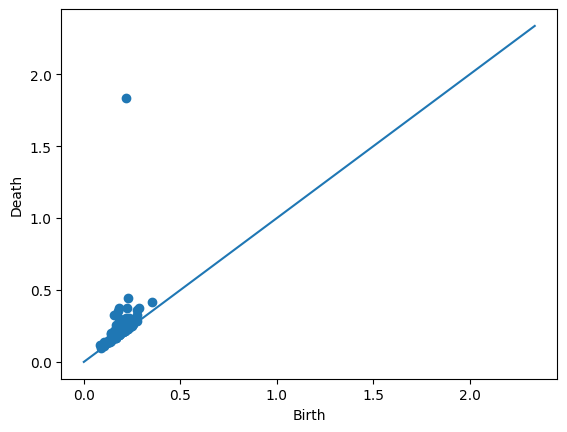

In [66]:
Draw.drawDgm(manifoldDF.loc[90]['Dgm1'])
plt.show()

We'll use the `PLandscape` class to generate the landscape functions for this particular persistence diagram.

In [67]:
PLC = Ff.PLandscape(manifoldDF.iloc[90,1])
type(PLC)

teaspoon.ML.feature_functions.PLandscape

This class stores lots of information about the landscape functions. 

In [68]:
print('There are a total of', PLC.PL_number, 'landscape functions.')

There are a total of 40 landscape functions.


All the functions are stored in the `.AllPL` data frame as seen here. 

In [69]:
PLC.AllPL.head()

Landscape Number                                             Points
0               1.0  [[0.08555641770362854, 0.0], [0.10098668932914...
1               2.0  [[0.0894632562994957, 0.0], [0.093510430306196...
2               3.0  [[0.09643901884555817, 0.0], [0.09699831157922...
3               4.0  [[0.10695430636405945, 0.0], [0.10710240155458...
4               5.0  [[0.12506087124347687, 0.0], [0.12696910649538...

So we can plot the first landscape manually if we wanted to. 

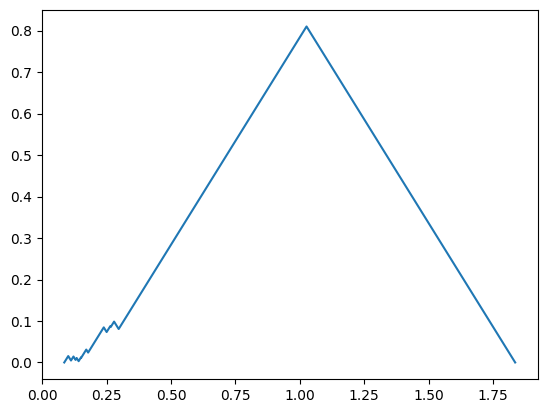

In [71]:
FirstFunc = PLC.AllPL.loc[0, 'Points']

plt.plot(FirstFunc[:,0], FirstFunc[:,1])
plt.show()

We also have code to plot more easily. The function below plots the landscape functions number 1 through 4 (this is caused by passing in `range(1,5)` which is `[1,2,3,4]`). 

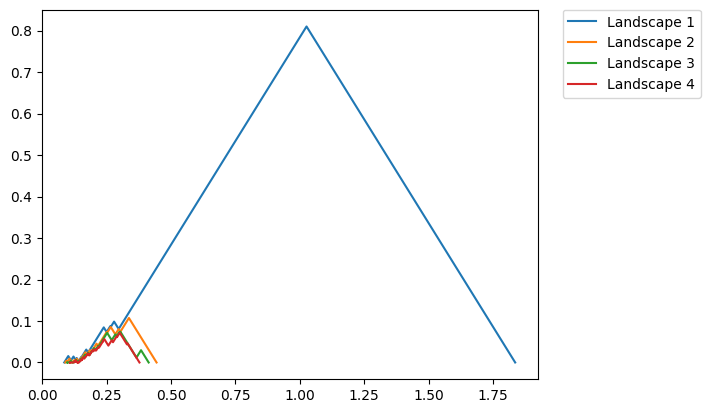

In [72]:
fig = PLC.PLandscape_plot(PLC.AllPL['Points'], range(1,5))
plt.show()

#### Do this: 

Find a row in `manifoldDF` that has one of the other manifold types. Compute and plot the landscapes. Do these look different than the annulus? 

In [73]:
# Your code here

#### Running a classifier with Landscapes 

We can similarly flatten out these landscape functions and pass them to a SVM. However, here we're going to use the `getPercentScore` function from teaspoon to speed up the process. Note that this function requires an input of a `parameterBucket` which stores all the parameters needed for ML training.

*Warning: The code below is slow, took about 5 minutes on my machine.*


In [ ]:
from sklearn.preprocessing import LabelEncoder
from teaspoon.ML.Base import ParameterBucket
from teaspoon.ML.PD_Classification import getPercentScore

labels_col='trainingLabel'
dgm_col='Dgm1'

# convert categorical labels into integers
label_encoder = LabelEncoder()
x = manifoldDF[labels_col]
y = label_encoder.fit_transform(x)
manifoldDF[labels_col] = y

# set classification parameters
params = ParameterBucket()
params.feature_function = Ff.F_Landscape
params.PL_Number = [1,2]
params.k_fold_cv=5
params.clf_model = SVC

# perform classification
c_report_train,c_report_test=getPercentScore(manifoldDF,
                                           labels_col='trainingLabel',
                                           dgm_col='Dgm1',
                                           params=params,
                                           precomputed = False,
                                           saving = False,
                                           saving_path = None)

Beginning experiments

Run Number: 1
Test set acc.: 0.983 
Training set acc.: 1.000
------------------------------
Run Number: 2
Test set acc.: 0.967 
Training set acc.: 1.000
------------------------------
Run Number: 3
Test set acc.: 1.000 
Training set acc.: 1.000
------------------------------
Run Number: 4
Test set acc.: 1.000 
Training set acc.: 1.000
------------------------------
Run Number: 5
Test set acc.: 0.983 
Training set acc.: 1.000
------------------------------

Finished with training/testing experiments

Test Set 
---------
Average accuracy: 0.987
Standard deviation: 0.012

Training Set 
---------
Average accuracy: 1.000
Standard deviation: 0.000

For more metrics, see the outputs.


#### Do this: 
Set up a similar classifier for the `simpleDF`. Does this representation do any better on classifying the diagrams?

In [88]:
# Your code here

### Persistence Images

Next we focus on persistence images, which give a function on the (rotated) plane by sticking a Gaussian at each point in the persistence diagram, weighted by distance to the diagonal. 

![Persistence Images](https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/Adams2017_1.png)

The code below computes the persistence images for the 1-dimensional diagrams in the manifold data set. 

In [122]:
Diagrams_H1 = manifoldDF['Dgm1'].sort_index().values
PS = 0.01
var = 0.01
feature_PI = Ff.F_Image(Diagrams_H1, PS, var, pers_imager = None,training=True, parallel=True)


The images themselves can be found in the `pers_images` entry of the `feature_PI` dictionary. 

In [124]:
feature_PI['pers_images'][0].shape

(182, 168)

Here are some plots of the first four persistence images from the `manifoldDF` data frame. 

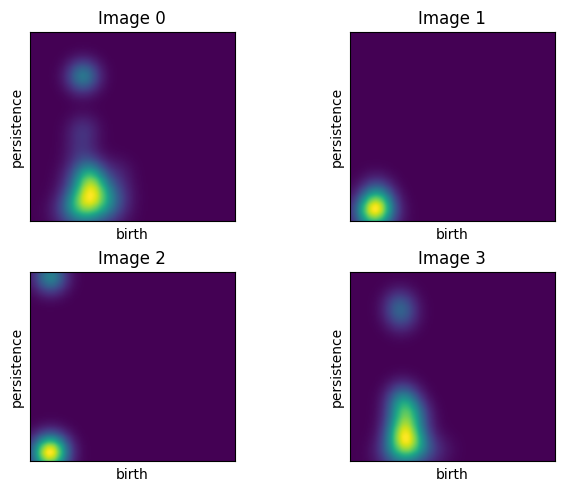

In [137]:
# plot example images
Ff.plot_F_Images(feature_PI, num_plots=4, rows = 2, cols = 2)

For comparison, the top left image comes from the following diagram. 

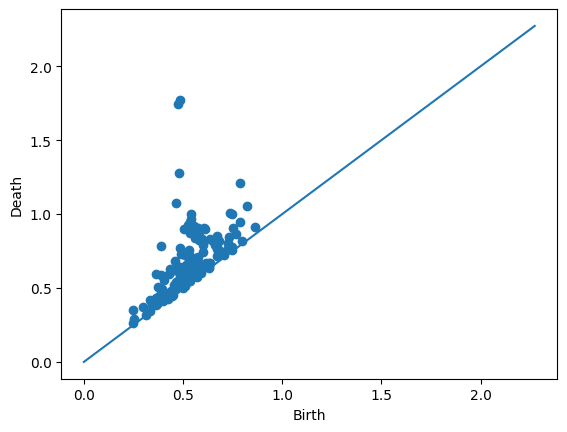

In [146]:
Draw.drawDgm(manifoldDF.loc[0]['Dgm1'])

The flatteded versions of the persistence images are stored in the `F_Matrix` part of the output. So, we can just pass this along to our favorite ML algorithm to train. 

In [145]:
X = feature_PI['F_Matrix']
y = np.array(manifoldDF['trainingLabel']).astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9888888888888889
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       0.94      1.00      0.97        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



#### Do this: 

Run a persistence images classifier for the `simpleDF` data set. Does this do better or worse than the other choices? 